In [2]:
import numpy as np
import pandas as pd
import warnings
import joblib

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from data_loading import EmotionDatasetPreparer
from preprocessing import AudioFeatureExtractor

import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
AUTOTUNE = tf.data.AUTOTUNE
rng = np.random.default_rng(42)

In [3]:
def train_test_split_e(df, random_state=16):
    """
    Split dataframe into train/val/test using emotion-based stratification.
    """
    # First split into train+temp (val+test)
    df_train, df_temp = train_test_split(
        df,
        test_size=0.3,
        stratify=df['emotion'],
        random_state=random_state
    )
    # Split temp into val and test
    df_val, df_test = train_test_split(
        df_temp,
        test_size=0.5,
        stratify=df_temp['emotion'],
        random_state=random_state
    )
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

In [4]:
# Data Loading
datasets = {
    "RAVDESS": "data/RAVDESS/",
    "CREMA-D": "data/AudioWAV",
    "TESS": "data/TESS/",
    "EmoDB": "data/EmoDB/",
    "IESC": "data/IESC/"
}
preparer = EmotionDatasetPreparer(datasets)
dfs = preparer.generate_csvs()
df = preparer.merge_and_clean(dfs)
print("Loaded dataset shape:", df.shape)
df.head()

Loaded dataset shape: (15617, 2)


,file_path,emotion
0,data/RAVDESS/Actor_01\03-01-01-01-01-01-01.wav,neutral
1,data/RAVDESS/Actor_01\03-01-01-01-01-02-01.wav,neutral
2,data/RAVDESS/Actor_01\03-01-01-01-02-01-01.wav,neutral
3,data/RAVDESS/Actor_01\03-01-01-01-02-02-01.wav,neutral
4,data/RAVDESS/Actor_01\03-01-02-01-01-01-01.wav,neutral


In [5]:
df_train, df_val, df_test = train_test_split_e(df)

print("Train samples:", len(df_train))
print("Val samples:", len(df_val))
print("Test samples:", len(df_test))

Train samples: 10931
Val samples: 2343
Test samples: 2343


In [6]:
# Feature Extraction
extractor = AudioFeatureExtractor(sample_rate=16000, n_mels=128, n_mfcc=40, max_len=200)

X_spec_train, X_pros_train, y_train = extractor.process_dataframe(df_train)
X_spec_val, X_pros_val, y_val = extractor.process_dataframe(df_val)
X_spec_test, X_pros_test, y_test = extractor.process_dataframe(df_test)

print("Train Spectrogram features:", X_spec_train.shape)
print("Train Prosodic features:", X_pros_train.shape)
print("Train Labels shape:", y_train.shape)

Extracting features...


  0%|          | 0/10931 [00:00<?, ?it/s]

100%|██████████| 10931/10931 [38:57<00:00,  4.68it/s]


Extracting features...


100%|██████████| 2343/2343 [05:09<00:00,  7.56it/s]


Extracting features...


100%|██████████| 2343/2343 [05:03<00:00,  7.72it/s]


Train Spectrogram features: (10931, 128, 200, 3)
Train Prosodic features: (10931, 9)
Train Labels shape: (10931,)


In [7]:
# Per-channel normalization for spectrograms (H, W, C)
spec_mean = X_spec_train.mean(axis=(0,1,2), keepdims=True)
spec_std  = X_spec_train.std(axis=(0,1,2), keepdims=True) + 1e-8
X_spec_train = (X_spec_train - spec_mean)/spec_std
X_spec_val   = (X_spec_val - spec_mean)/spec_std
X_spec_test  = (X_spec_test - spec_mean)/spec_std

np.save("artifacts/spec_mean.npy", spec_mean)
np.save("artifacts/spec_std.npy", spec_std)

# Prosodic normalization
scaler = StandardScaler()
X_pros_train_scaled = scaler.fit_transform(X_pros_train)
X_pros_val_scaled = scaler.transform(X_pros_val)
X_pros_test_scaled = scaler.transform(X_pros_test)


# Encode labels
le = LabelEncoder()
le.fit(list(y_train) + list(y_val) + list(y_test))

# Encode labels as integers
y_train_idx = le.transform(y_train)
y_val_idx   = le.transform(y_val)
y_test_idx  = le.transform(y_test)

# Convert to one-hot
y_train_cat = to_categorical(y_train_idx)
y_val_cat   = to_categorical(y_val_idx)
y_test_cat  = to_categorical(y_test_idx)

# Info
num_classes = y_train_cat.shape[1]
print("Classes:", list(le.classes_))
print("Shapes:", y_train_cat.shape, y_val_cat.shape, y_test_cat.shape)

joblib.dump(scaler, "artifacts/pros_scaler.pkl")
joblib.dump(le, "artifacts/label_encoder.pkl")

Classes: [np.str_('angry'), np.str_('disgust'), np.str_('fear'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprised')]
Shapes: (10931, 7) (2343, 7) (2343, 7)


['artifacts/label_encoder.pkl']

In [9]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_idx),
    y=y_train_idx
)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Stage 1: Train Spectrogram CNN

def build_cnn_spec_model(input_shape, num_classes, l2_reg=5e-5, filters=[32,64,128], dropout=0.3):
    spec_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters[0], (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg))(spec_input)
    x = layers.BatchNormalization()(x)
    
    for f in filters:
        shortcut = x
        if shortcut.shape[-1] != f:
            shortcut = layers.Conv2D(f, (1,1), padding='same', kernel_regularizer=regularizers.l2(l2_reg))(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Conv2D(f, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(f, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([shortcut, x])
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Dropout(dropout)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=spec_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Train Stage 1 CNN
cnn_model = build_cnn_spec_model(X_spec_train.shape[1:], num_classes=num_classes)
es = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
mc = ModelCheckpoint("cnn_stage1_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)

history = cnn_model.fit(
    X_spec_train, 
    y_train_cat,
    validation_data=(X_spec_val, y_val_cat),
    batch_size=32, epochs=70,
    callbacks=[es, rlr, mc],
     class_weight=class_weight_dict
)

Epoch 1/70
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2257 - loss: 1.8469
Epoch 1: val_accuracy improved from None to 0.24456, saving model to cnn_stage1_model.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 845s 2s/step - accuracy: 0.2926 - loss: 1.6758 - val_accuracy: 0.2446 - val_loss: 1.8053 - learning_rate: 0.0010
Epoch 2/70
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4249 - loss: 1.3850
Epoch 2: val_accuracy improved from 0.24456 to 0.40205, saving model to cnn_stage1_model.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 829s 2s/step - accuracy: 0.4558 - loss: 1.3298 - val_accuracy: 0.4020 - val_loss: 1.6223 - learning_rate: 0.0010
Epoch 3/70
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5134 - loss: 1.2012
Epoch 3: val_accuracy improved from 0.40205 to 0.60094, saving model to cnn_stage1_model.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 829s 2s/step - accuracy: 0.5290 - loss: 1.1736 - val_accuracy: 0.6009 - val_loss: 1.0922 - learning_rate: 0.0010
Epoch 4/70
342/342 ━━━━━━━━━━━━━━━━━━

74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 506ms/step


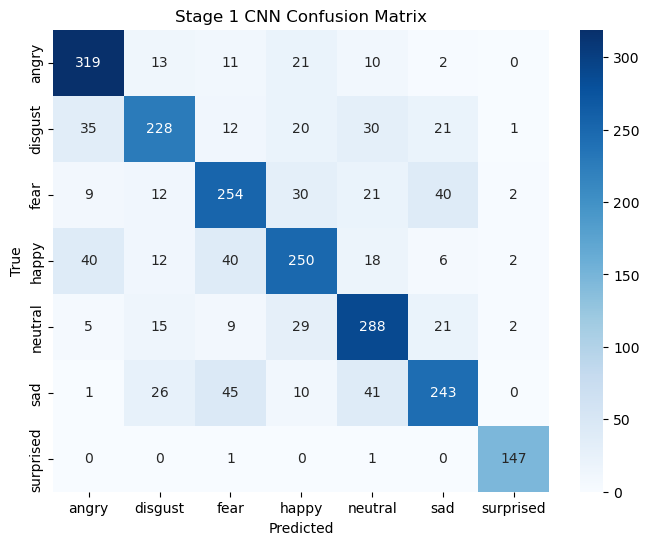

In [ ]:
y_pred_cnn = cnn_model.predict(X_spec_test)
y_pred_labels_cnn = np.argmax(y_pred_cnn, axis=1)
y_true_labels_cnn = np.argmax(y_test_cat, axis=1)

cm_cnn = confusion_matrix(y_true_labels_cnn, y_pred_labels_cnn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Stage 1 CNN Confusion Matrix')
plt.show()

In [17]:
print("Stage 1 CNN Classification Report:")
print(classification_report(y_true_labels_cnn, y_pred_labels_cnn, target_names=le.classes_))

Stage 1 CNN Classification Report:
              precision    recall  f1-score   support

       angry       0.78      0.85      0.81       376
     disgust       0.75      0.66      0.70       347
        fear       0.68      0.69      0.69       368
       happy       0.69      0.68      0.69       368
     neutral       0.70      0.78      0.74       369
         sad       0.73      0.66      0.70       366
   surprised       0.95      0.99      0.97       149

    accuracy                           0.74      2343
   macro avg       0.76      0.76      0.76      2343
weighted avg       0.74      0.74      0.74      2343



In [12]:
# Stage 2: Hybrid CNN + Prosodic MLP
cnn_model = build_cnn_spec_model(X_spec_train.shape[1:], num_classes=num_classes)
cnn_model.load_weights("cnn_stage1_model.keras")

# Freeze lower CNN layers, fine-tune top
for layer in cnn_model.layers[:-3]:
    layer.trainable = False

spec_input = cnn_model.input
x = cnn_model.layers[-3].output

pros_input = layers.Input(shape=X_pros_train_scaled.shape[1:])
y = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(pros_input)
y = layers.Dropout(0.4)(y)
y = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(y)
y = layers.Dropout(0.4)(y)

# Concatenate CNN + prosodic features
combined = layers.concatenate([x, y])
z = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(combined)
z = layers.Dropout(0.5)(z)
output = layers.Dense(num_classes, activation='softmax')(z)

hybrid_model = models.Model(inputs=[spec_input, pros_input], outputs=output)
hybrid_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train Hybrid Model
es = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
mc = ModelCheckpoint("hybrid_ser_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)

history = hybrid_model.fit(
    [X_spec_train, X_pros_train_scaled], y_train_cat,
    validation_data=([X_spec_val, X_pros_val_scaled], y_val_cat),
    batch_size=32, epochs=50,
    callbacks=[es, rlr, mc],
     class_weight=class_weight_dict
)

Epoch 1/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.6220 - loss: 1.0205
Epoch 1: val_accuracy improved from None to 0.75075, saving model to hybrid_ser_model.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 237s 682ms/step - accuracy: 0.7187 - loss: 0.7705 - val_accuracy: 0.7507 - val_loss: 0.7556 - learning_rate: 0.0010
Epoch 2/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.7768 - loss: 0.6008
Epoch 2: val_accuracy did not improve from 0.75075
342/342 ━━━━━━━━━━━━━━━━━━━━ 216s 633ms/step - accuracy: 0.7800 - loss: 0.5935 - val_accuracy: 0.7469 - val_loss: 0.7565 - learning_rate: 0.0010
Epoch 3/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7876 - loss: 0.5777
Epoch 3: val_accuracy improved from 0.75075 to 0.75416, saving model to hybrid_ser_model.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 215s 629ms/step - accuracy: 0.7900 - loss: 0.5703 - val_accuracy: 0.7542 - val_loss: 0.7619 - learning_rate: 0.0010
Epoch 4/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accurac

In [ ]:
# Evaluate
test_loss, test_acc = hybrid_model.evaluate([X_spec_test, X_pros_test_scaled], y_test_cat)
print(f"Test Accuracy: {test_acc*100:.2f}%")

74/74 ━━━━━━━━━━━━━━━━━━━━ 37s 493ms/step - accuracy: 0.7384 - loss: 0.7648
Test Accuracy: 73.84%


74/74 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step


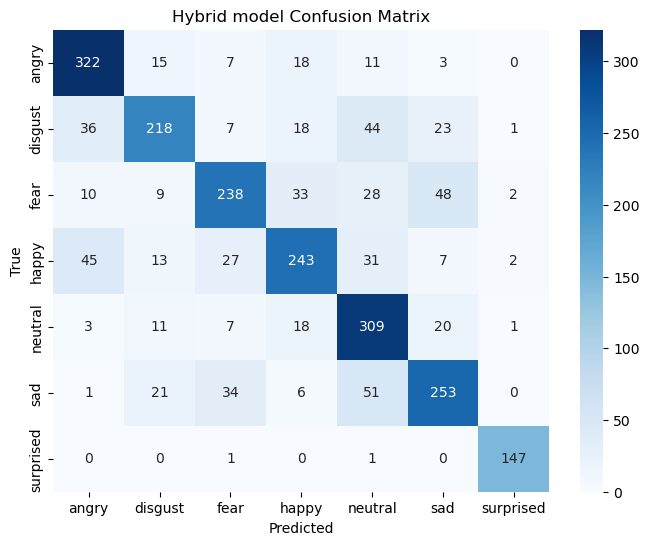

In [ ]:
# Predict on test set
y_pred = hybrid_model.predict([X_spec_test, X_pros_test_scaled])
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Hybrid model Confusion Matrix')
plt.show()

In [18]:
print("Hybrid Model Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

Hybrid Model Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.86      0.81       376
     disgust       0.76      0.63      0.69       347
        fear       0.74      0.65      0.69       368
       happy       0.72      0.66      0.69       368
     neutral       0.65      0.84      0.73       369
         sad       0.71      0.69      0.70       366
   surprised       0.96      0.99      0.97       149

    accuracy                           0.74      2343
   macro avg       0.76      0.76      0.76      2343
weighted avg       0.74      0.74      0.74      2343

